# Analysis, Cleaning and Visualization of Used Car Dataset obtained by Scraping Kijiji

In [201]:
import warnings
warnings.filterwarnings('ignore')

In [202]:
#Importing required modules
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,inspect, func
from config import password

import seaborn as sns
import scipy.stats as ss
from collections import Counter
import math 
from scipy import stats
import datetime
import matplotlib
import pickle
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from spark_sklearn import GridSearchCV
from spark_sklearn.util import createLocalSparkSession
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

from statsmodels.graphics.tsaplots import plot_acf
import sqlite3

In [203]:
#Connecting to the sql database
connection_string = "postgres:"+password+"@localhost:5432/hondadb"
engine = create_engine(f'postgresql://{connection_string}')

In [245]:
# Reading the data from sql database
sql_DF = pd.read_sql("SELECT * FROM cardb",
                     con=engine)

In [246]:
#Selecting the useful columns only and removing unuseful columns
csql_DF=sql_DF[['Car Type', 'Model', 'Price', 'Milage', 'Year']]

In [247]:
csql_DF.head()

,Car Type,Model,Price,Milage,Year
0,Ford,F-150,33888,64965,2018
1,Mercedes-Benz,GLS,54887,57449,2017
2,Dodge,Journey,18888,28567,2016
3,Ford,Edge,30995,63500,2017
4,Nissan,Versa,18988,87760,2019


In [248]:
#Checking for duplicates
csql_DF.duplicated(subset=None, keep='first')

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
40963    False
40964    False
40965    False
40966    False
40967    False
40968    False
40969    False
40970    False
40971    False
40972    False
40973    False
40974    False
40975    False
40976    False
40977    False
40978    False
40979    False
40980    False
40981    False
40982    False
40983    False
40984    False
40985    False
40986    False
40987    False
40988    False
40989    False
40990    False
40991    False
40992    False
Length: 40993, dtype: bool

In [249]:
#Droping duplicate
df=csql_DF.drop_duplicates(subset=None, keep='first')

In [250]:
#Checking the dataset
df.describe()

,Car Type,Model,Price,Milage,Year
count,40991,40991,40991,40991,40991
unique,70,1014,14952,27261,77
top,Ford,F-150,14995,90,2020
freq,4919,1729,199,97,9748


In [251]:
#converting the Milage, Year and Price values to numeric
df['Milage'] = pd.to_numeric(df['Milage'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)

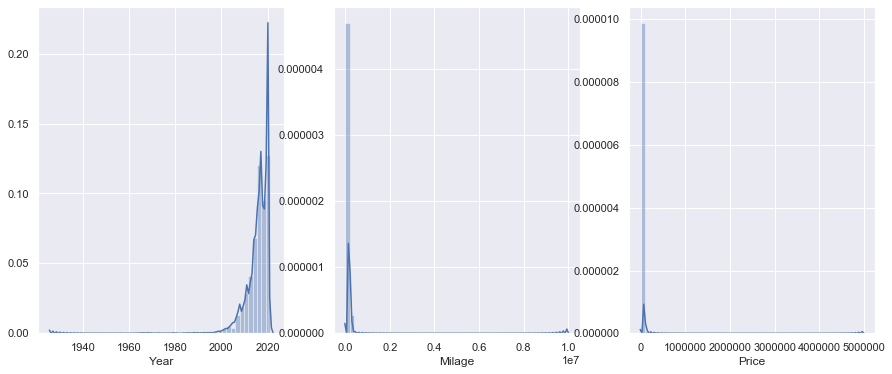

In [252]:
#Plotting out distributions for the numeric variables to see whether they are normally distributed
warnings.filterwarnings("ignore")
sns.set()
fig, ((ax1,ax2,ax3))=plt.subplots(ncols=3,nrows=1,figsize=(15,6)) 
sns.distplot(df['Year'],ax=ax1);
sns.distplot(df['Milage'],ax=ax2);            
sns.distplot(df['Price'],ax=ax3);

In [253]:
#removing some obvious outliers in model year, milage and price
df = df[(df.Year >= 1989)
      & (df.Milage <= 500000)
      & (df.Price <= 200000)]

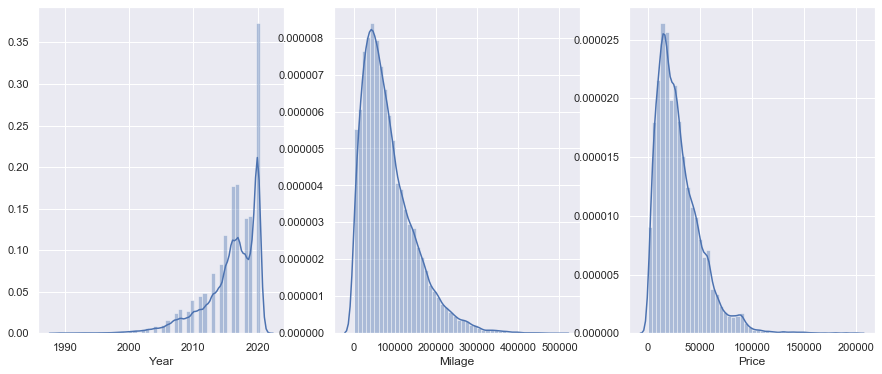

In [254]:
#Plotting out distributions for the numeric variables to see whether they are normally distributed again after removing obvious outliers
warnings.filterwarnings("ignore")
sns.set()
fig, ((ax1,ax2,ax3))=plt.subplots(ncols=3,nrows=1,figsize=(15,6)) 
sns.distplot(df['Year'],ax=ax1);
sns.distplot(df['Milage'],ax=ax2);            
sns.distplot(df['Price'],ax=ax3);

Text(0, 0.5, 'Count of cars')

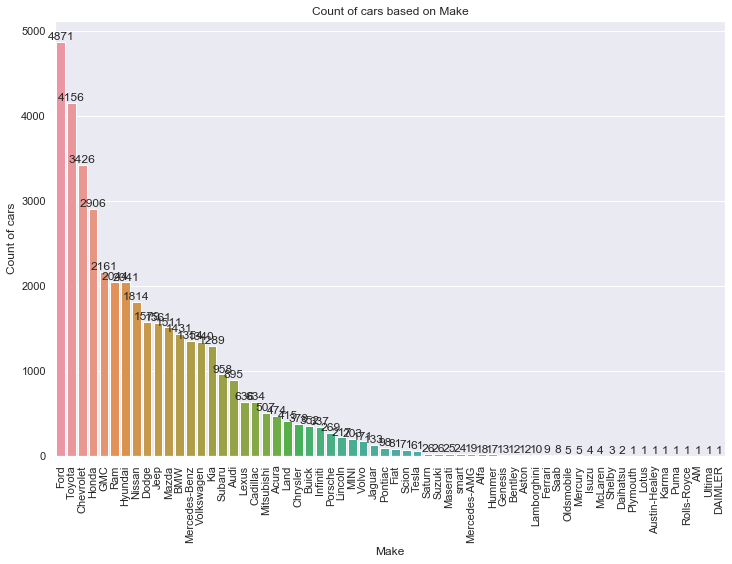

In [255]:
#Plotting the number of each cars make
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Car Type', data = df, order = df['Car Type'].value_counts().index)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on Make")
plt.xlabel("Make")
plt.ylabel("Count of cars")

Text(0, 0.5, 'Count of cars')

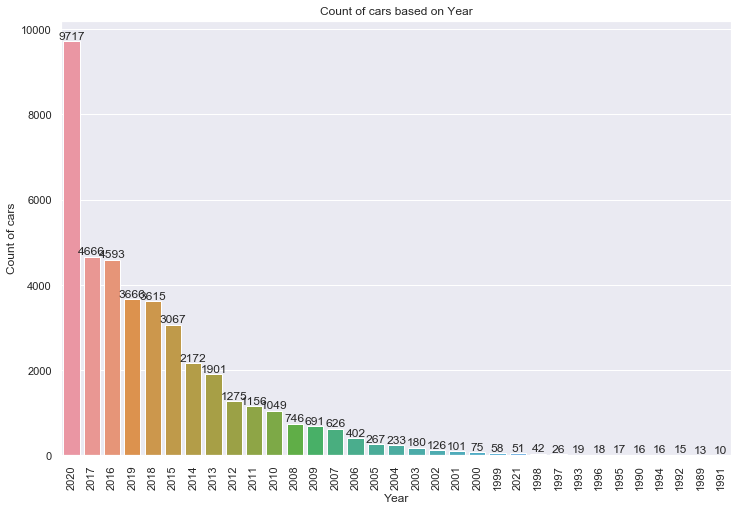

In [256]:
#Plotting the number of model years
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Year', data = df, order = df['Year'].value_counts().index)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on Year")
plt.xlabel("Year")
plt.ylabel("Count of cars")

Text(0, 0.5, 'Price')

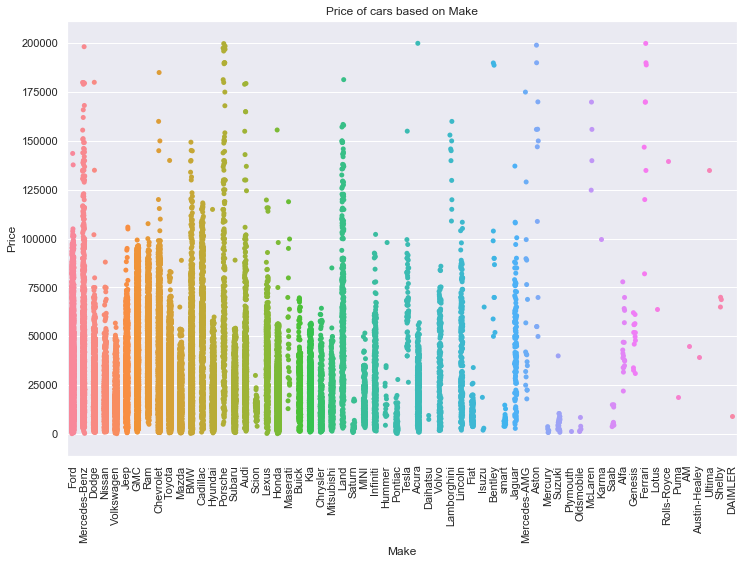

In [257]:
#checking the prices of each make
plt.figure(figsize = (12, 8))

ax=sns.stripplot(x='Car Type',y='Price', data=df)

plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Price of cars based on Make")
plt.xlabel("Make")
plt.ylabel("Price")

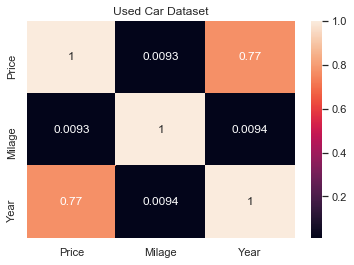

In [258]:
#checking the correlations between numerical values in the dataset
numeric_corr = df[['Price','Milage','Year']].corr(method='spearman'); # non-parametric
sns.heatmap(numeric_corr,annot=True);
plt.title('Used Car Dataset');

#### Analysis of the Price feature

In [259]:
# Converting all objects and strings to numberic values
df['Milage'] = pd.to_numeric(df['Milage'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)

In [260]:
df['Price'].describe()

count     40625.000000
mean      29955.204086
std       21591.735858
min         200.000000
25%       14499.000000
50%       24995.000000
75%       40495.000000
max      199950.000000
Name: Price, dtype: float64

In [261]:
df['Milage'].describe()

count     40625.000000
mean      84053.145157
std       63849.692864
min           3.000000
25%       37354.000000
50%       69000.000000
75%      116062.000000
max      500000.000000
Name: Milage, dtype: float64

In [262]:
df['Year'].describe()

count    40625.000000
mean      2015.842437
std          4.344107
min       1989.000000
25%       2014.000000
50%       2017.000000
75%       2019.000000
max       2021.000000
Name: Year, dtype: float64

Skewness: 1.663365
Kurtosis: 5.057019


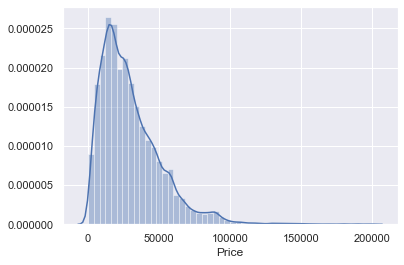

In [263]:
sns.distplot(df['Price'])
#skewness and kurtosis
print("Skewness: %f" % df['Price'].skew())
print("Kurtosis: %f" % df['Price'].kurt())

The data are skewed (skewness = 1.66) and have a kurtosis of 5.05 which means there are still outliers in data.

#### Investigation of Corelations (Numerical Features)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


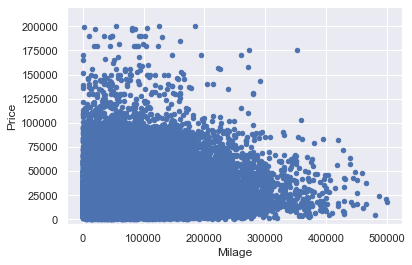

In [264]:
# distribution of  Milage / Price
data = pd.concat([df['Price'], df['Milage']], axis=1)
data.plot.scatter(x='Milage', y='Price', ylim=(-5000,220000));

It cen be observed that lesser is the milage, the higher tends to be the price. Price and Milage are in a reverse correlation. Some milage bins show some outliers.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


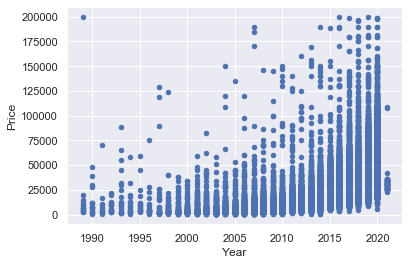

In [265]:
# distribution of  Year / Price
data = pd.concat([df['Price'], df['Year']], axis=1)
data.plot.scatter(x='Year', y='Price');#, ylim=(-5000,220000));

From the plot above, It cen be observed that the newer the car, the higher the price will be. Price and model year are in a direct correlation. One outlier is observed where the car is very old however the price is high which might be because of the cars being a classic car. We will remove that car.

In [271]:
outlier = df[(df['Price']>100000) & (df['Year']<1990)]
outlier

,Car Type,Model,Price,Milage,Year
26214,Ferrari,328,199900,184901,1989


In [274]:
#removing the outlier
df=df[df['Price']!=199900]

<Figure size 2160x2160 with 0 Axes>

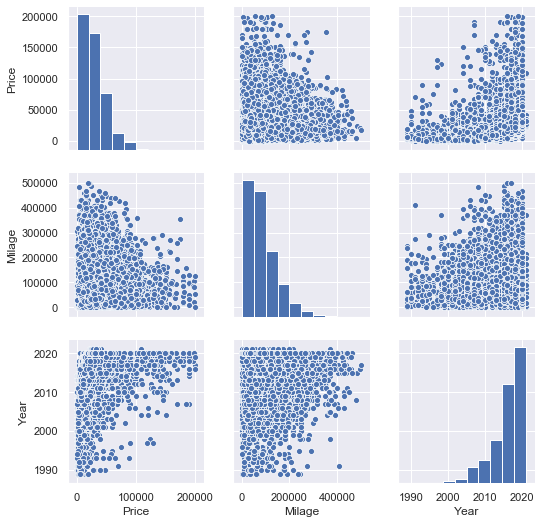

In [275]:
# PairPlots to have more insight into the correlations between numerical features
plt.figure(figsize = (30,30))
sns.pairplot(df)
plt.show()

#### Investigation of Corelations (categorical Features)

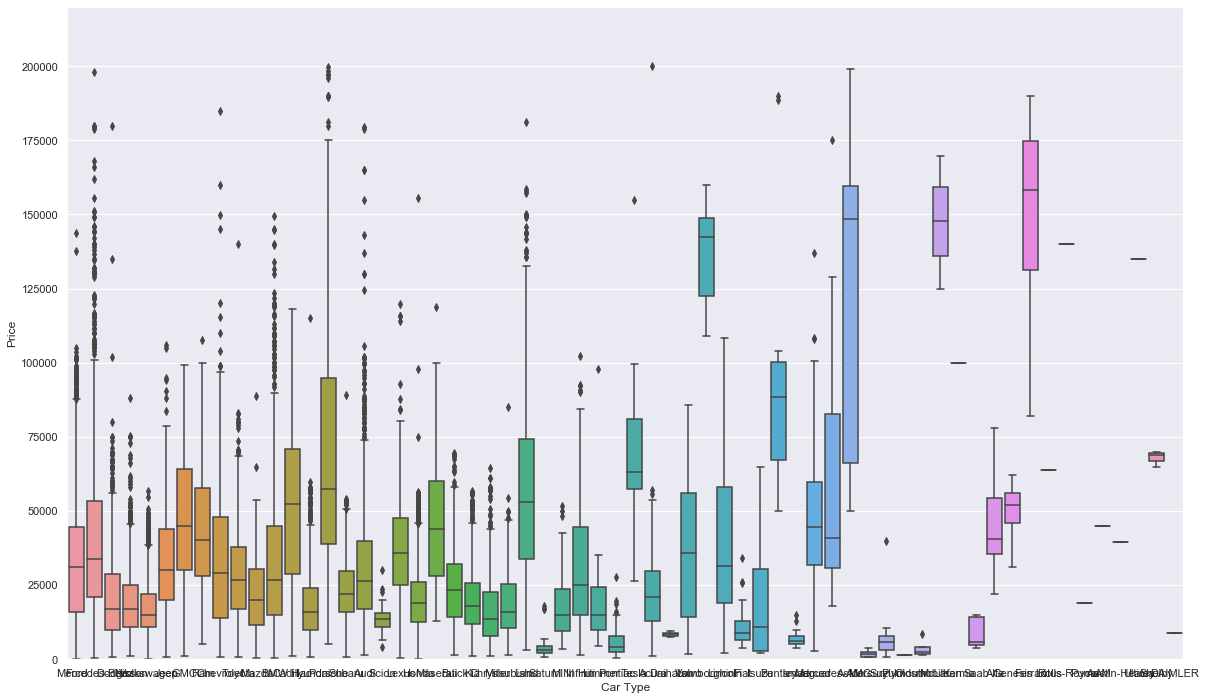

In [276]:
# Box plot Make Model/Price
data = pd.concat([df['Price'], df['Car Type']], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x="Car Type", y="Price", data=data)
fig.axis(ymin=0, ymax=220000);

We can clearly see that some makes are more expensive that others. There are still some outliers in data for different makes.

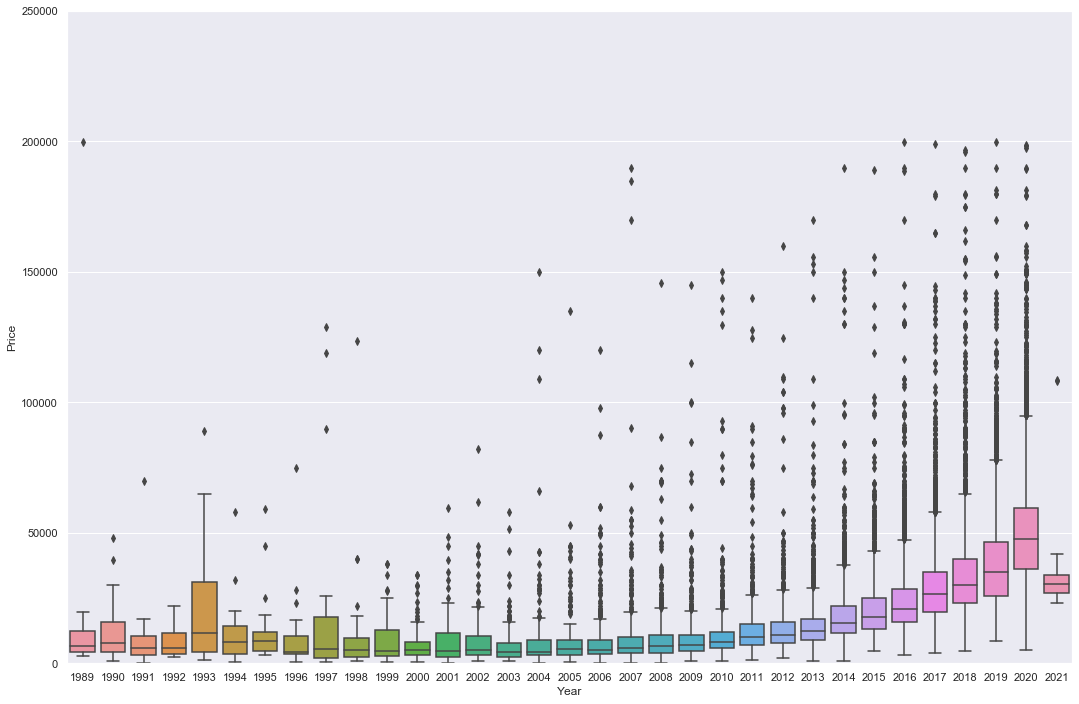

In [156]:
# Box plot Year/Price
data = pd.concat([df['Price'], df['Year']], axis=1)
f, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x='Year', y="Price", data=data)
fig.axis(ymin=0, ymax=250000);

Obviously there is a correlation bertween the year (model year) and the price. The newer the car, the higher the price. Again many outliers are observed in data.

#### Investigation of the Importance of Features Related to Target

In [277]:
# Finding most important features relative to Price
corr = df.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

Price     1.000000
Year      0.570298
Milage    0.007439
Name: Price, dtype: float64


Between the year (model year) and price there is a direct correlation and the newer the car the higher will be the price. 

#### Preprocessing

In [278]:
# Checking for missing values -> no missing values
df.isnull().sum()

Car Type    0
Model       0
Price       0
Milage      0
Year        0
dtype: int64

In [279]:
# Checking for values of numerical features
# we need to fix these problems
df.describe()

,Price,Milage,Year
count,40624.000000,40624.000000,40624.000000
mean,29951.020727,84050.662687,2015.843098
std,21575.531477,63848.518161,4.342119
min,200.000000,3.000000,1989.000000
25%,14499.000000,37354.000000,2014.000000
50%,24995.000000,69000.000000,2017.000000
75%,40489.750000,116059.000000,2019.000000
max,199950.000000,500000.000000,2021.000000


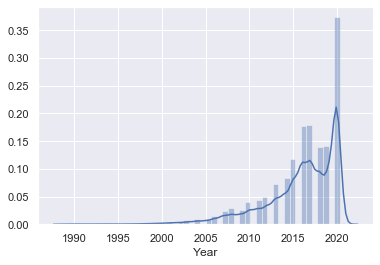

In [280]:
# Record distribution over the year
sns.distplot((df["Year"]))

In [282]:
# Checking values of categorical features
cat_val = ["Model", "Car Type"]
for col in cat_val:
    print ([col]," : ", csql_DF[col].unique())

['Model']  :  ['F-150' 'GLS' 'Journey' ... 'CBR600' 'Chrysler' 'G25X']
['Car Type']  :  ['Ford' 'Mercedes-Benz' 'Dodge' 'Nissan' 'Volkswagen' 'Jeep' 'GMC' 'Ram'
 'Chevrolet' 'Toyota' 'Mazda' 'BMW' 'Cadillac' 'Hyundai' 'Porsche'
 'Subaru' 'Audi' 'Scion' 'Lexus' 'Honda' 'Maserati' 'Buick' 'Kia'
 'Chrysler' 'Mitsubishi' 'Land' 'Saturn' 'MINI' 'Pontiac' 'Infiniti'
 'Hummer' 'Tesla' 'Acura' 'Oldsmobile' 'Mercury' 'Daihatsu' 'Volvo'
 'Lamborghini' 'Lincoln' 'Fiat' 'Isuzu' 'Ferrari' 'Bentley' 'smart'
 'Jaguar' 'Alfa' 'Mercedes-AMG' 'Aston' 'Datsun' 'Suzuki' 'MG' 'Plymouth'
 'De' 'McLaren' 'Karma' 'Saab' 'Rolls-Royce' 'Triumph' 'Genesis' 'Lotus'
 'Puma' 'AM' 'Austin' 'Shelby' 'Austin-Healey' 'Ultima' 'International'
 'Nash' 'Avanti-Studebaker' 'DAIMLER']


#### Outlier management


##### Bivariate Analysis

##### Removing Outliers by Model



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


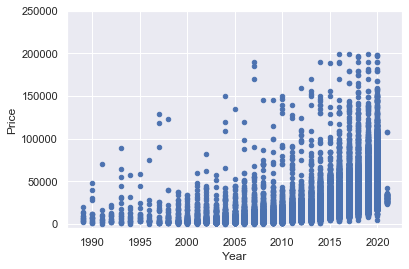

In [289]:
# Bivariate analysis Price / Year
data = pd.concat([df['Price'], df['Year']], axis=1)
data.plot.scatter(x='Year', y='Price', ylim=(-5000,250000));

We will only use the data between 20 and 80 percentile of the price guassian curve.

In [291]:
from numpy import percentile
from functools import partial

category='Model'

models = df[category].unique()


p20 = df.groupby(by=category)[category,'Price'].agg(lambda x: percentile(x['Price'], 20))
p80 = df.groupby(by=category)[category,'Price'].agg(lambda x: percentile(x['Price'], 80))

In [292]:
# Now this strategy is applied to the 3k models
# depending on the hardware
models = df[category].unique()

cdf = pd.DataFrame()

for i,m in enumerate(models):
    cdf=cdf.append(df[( (df[category] == m ) & ( (df["Price"] > p20.Model[m]) & (df["Price"] <= p80.Model[m])) ) ],ignore_index=True)

In [293]:
cdf

,Car Type,Model,Price,Milage,Year
0,Ford,F-150,33888,64965,2018
1,Ford,F-150,46980,100000,2018
2,Ford,F-150,29995,88300,2016
3,Ford,F-150,43701,74900,2020
4,Ford,F-150,49950,73987,2019
5,Ford,F-150,34999,58443,2018
6,Ford,F-150,36999,74526,2016
7,Ford,F-150,26379,35400,2016
8,Ford,F-150,35994,79950,2019
9,Ford,F-150,31995,133000,2016


#### Create database connection

In [294]:
from config import password
connection_string = "postgres:"+password+"@localhost:5432/hondadb"
engine = create_engine(f'postgresql://{connection_string}')

In [295]:
cdf.to_sql(name='cleanedcardb', con=engine, if_exists='replace', index=True)

In [296]:
csql_DF_cleaned = pd.read_sql("SELECT * FROM cleanedcardb",
                     con=engine)

In [297]:
csql_DF_cleaned.describe()

,index,Price,Milage,Year
count,23707.000000,23707.000000,23707.000000,23707.00000
mean,11853.000000,29524.735479,83906.444088,2016.57076
std,6843.765752,17250.757844,63810.344233,3.14560
min,0.000000,1495.000000,3.000000,1989.00000
25%,5926.500000,16779.500000,37306.500000,2015.00000
50%,11853.000000,25986.000000,69000.000000,2017.00000
75%,17779.500000,38985.500000,116000.000000,2019.00000
max,23706.000000,169800.000000,500000.000000,2021.00000


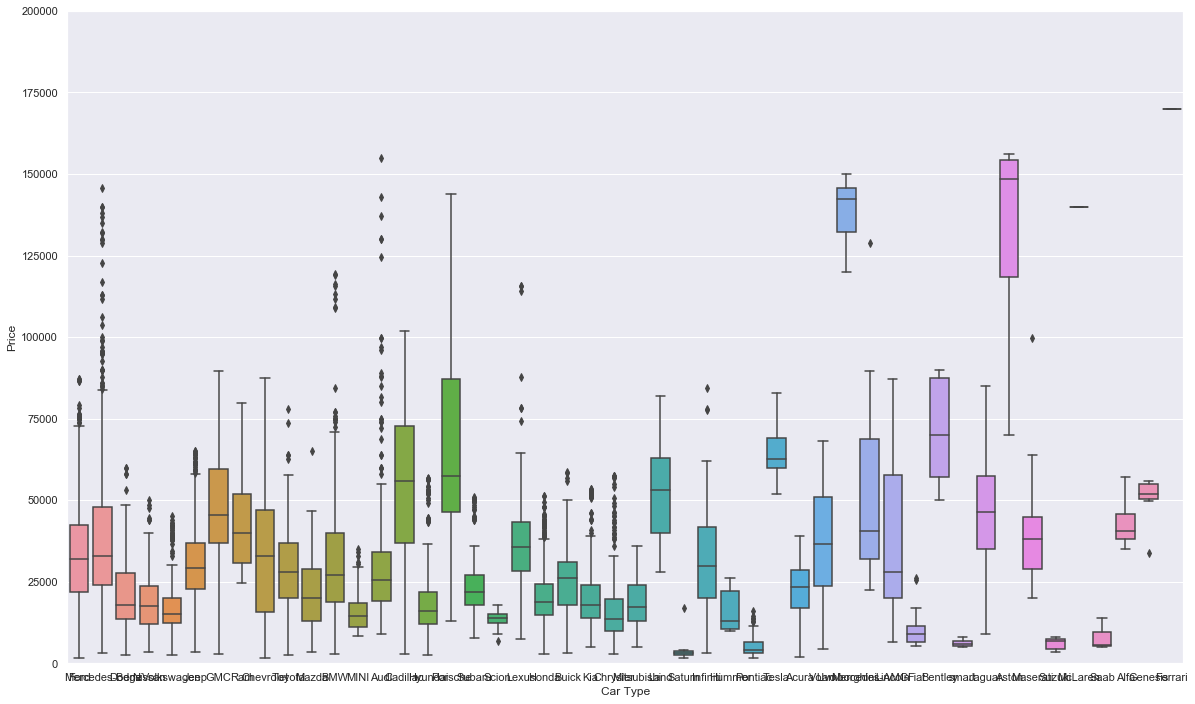

In [298]:
# Box Plot showing car manufacturer / Price range after cleaning

data = pd.concat([csql_DF_cleaned['Price'], csql_DF_cleaned['Car Type']], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x='Car Type', y="Price", data=data)
fig.axis(ymin=0, ymax=200000);

In [299]:
print("Too old: %d" % csql_DF_cleaned.loc[csql_DF_cleaned.Year <= 1995].count()['index'])
print("Too new: %d" % csql_DF_cleaned.loc[csql_DF_cleaned.Year >= 2021].count()['index'])
print("Too few km: " , csql_DF_cleaned.loc[csql_DF_cleaned.Milage <= 10].count()['index'])
print("Too many km: " , csql_DF_cleaned.loc[csql_DF_cleaned.Milage >= 400000].count()['index'])


Too old: 21
Too new: 28
Too few km:  23
Too many km:  26


In [300]:
# Replace the NaN values for categoric attributes
csql_DF_cleaned['Model'].fillna(value='blank', inplace=True)

# Drop duplicates
csql_DF_cleaned = csql_DF_cleaned.drop_duplicates(["Year", "Milage", "Price", "Model", "Car Type"])
csql_DF_cleaned.drop_duplicates(keep=False, inplace=True)
# Remove outliers
csql_DF_cleaned = csql_DF_cleaned[
        (csql_DF_cleaned.Year >= 1995) 
      & (csql_DF_cleaned.Year <= 2021)  
      & (csql_DF_cleaned.Milage >= 10) 
      & (csql_DF_cleaned.Milage <= 500000)
      & (csql_DF_cleaned.Price <= 400000)]

In [301]:
csql_DF_cleaned.describe()

,index,Price,Milage,Year
count,23677.000000,23677.000000,23677.000000,23677.000000
mean,11846.972801,29529.070026,83959.113359,2016.588588
std,6841.809995,17251.225185,63801.946178,3.075055
min,0.000000,1495.000000,10.000000,1995.000000
25%,5922.000000,16786.000000,37344.000000,2015.000000
50%,11844.000000,25985.000000,69000.000000,2017.000000
75%,17772.000000,38987.000000,116000.000000,2019.000000
max,23706.000000,169800.000000,500000.000000,2021.000000


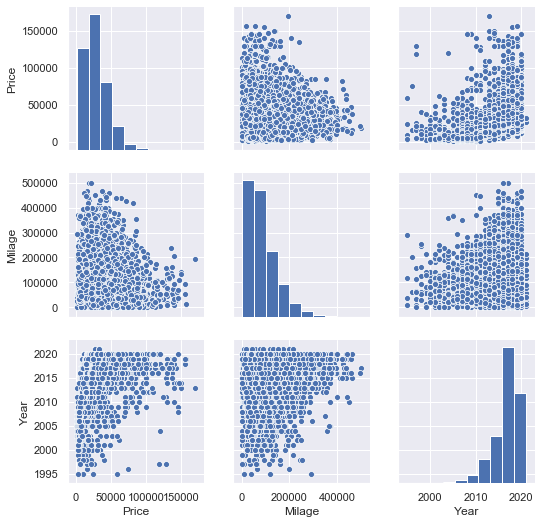

In [302]:
# pairplot for numerical features
num_features = ["Price", "Milage", "Year"]
sns.pairplot(csql_DF_cleaned[num_features], size = 2.5)
plt.show();

In [303]:
csql_DF_cleaned.describe()


,index,Price,Milage,Year
count,23677.000000,23677.000000,23677.000000,23677.000000
mean,11846.972801,29529.070026,83959.113359,2016.588588
std,6841.809995,17251.225185,63801.946178,3.075055
min,0.000000,1495.000000,10.000000,1995.000000
25%,5922.000000,16786.000000,37344.000000,2015.000000
50%,11844.000000,25985.000000,69000.000000,2017.000000
75%,17772.000000,38987.000000,116000.000000,2019.000000
max,23706.000000,169800.000000,500000.000000,2021.000000


#### Normalizing the distribution of Prices

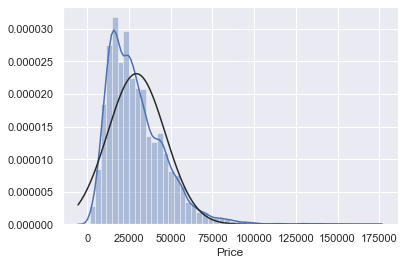

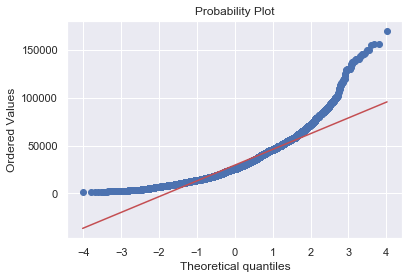

In [304]:
# Distribution of prices
from scipy.stats import norm
from scipy import stats

# Using Histogram and normal probability plot
sns.distplot(csql_DF_cleaned['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(csql_DF_cleaned['Price'], plot=plt)

In [305]:
# Finding most important features relative to Price
corr = csql_DF_cleaned.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

Price     1.000000
Year      0.516431
Milage   -0.005766
index    -0.049187
Name: Price, dtype: float64


In [306]:
#applying log transformation
csql_DF_cleaned['Price'] = np.log(csql_DF_cleaned['Price'])

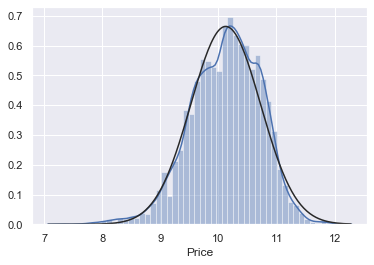

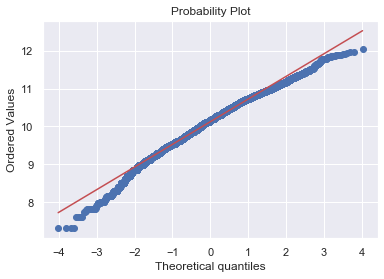

In [307]:
#transformed histogram and normal probability plot
sns.distplot(csql_DF_cleaned['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(csql_DF_cleaned['Price'], plot=plt)

In [308]:
# Finding most important features relative to Price
corr = csql_DF_cleaned.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

Price     1.000000
Year      0.644284
Milage   -0.004134
index    -0.117610
Name: Price, dtype: float64


In [309]:
csql_DF_cleaned.describe()

,index,Price,Milage,Year
count,23677.000000,23677.000000,23677.000000,23677.000000
mean,11846.972801,10.125652,83959.113359,2016.588588
std,6841.809995,0.600556,63801.946178,3.075055
min,0.000000,7.309881,10.000000,1995.000000
25%,5922.000000,9.728300,37344.000000,2015.000000
50%,11844.000000,10.165275,69000.000000,2017.000000
75%,17772.000000,10.570984,116000.000000,2019.000000
max,23706.000000,12.042377,500000.000000,2021.000000


In [310]:
csql_DF_cleaned.to_sql(name='cleanedcardb2', con=engine, if_exists='replace', index=True)

In [311]:
conn = sqlite3.connect('cleanedcar.sqlite')
csql_DF_cleaned.to_sql('cleanedcarsdb', conn, if_exists='replace', index=False)